In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
import pandas as pd

In [2]:
Image_size=256
Batch_size=32
Channels=3
Epochs=50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Training",
    shuffle=True,
    image_size=(Image_size,Image_size),
    batch_size=Batch_size
)

Found 5712 files belonging to 4 classes.


In [4]:
class_names=dataset.class_names
print(class_names)
print(len(dataset))

['glioma', 'meningioma', 'notumor', 'pituitary']
179


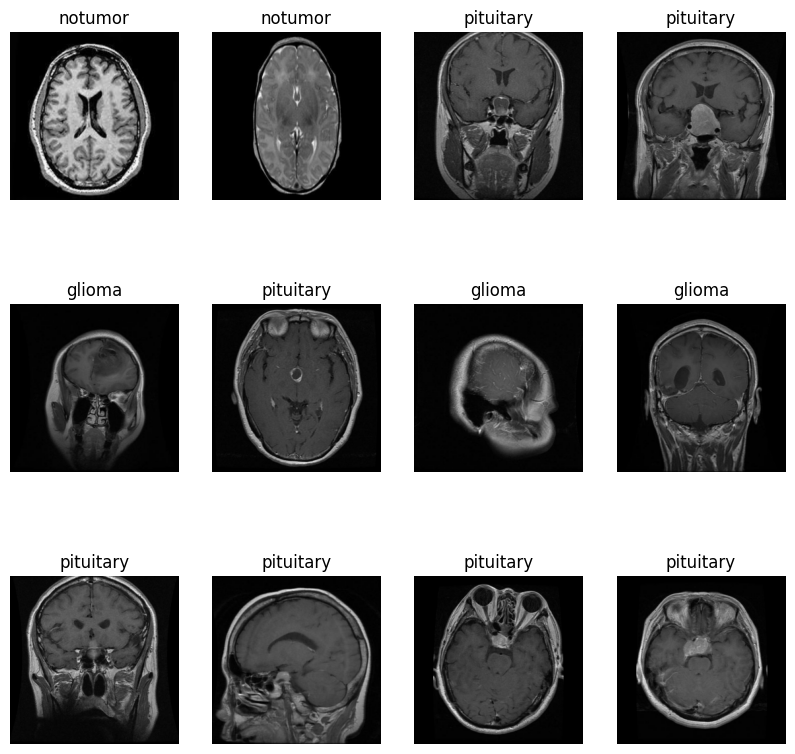

In [5]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [6]:
# Train , Test Split  80%==>Train  10%==>Test   10%==>Validation

train_size=0.8
Train_dataset=dataset.take(143) # Train dataset
print(len(Train_dataset))
Test_dataset=dataset.skip(143) # Test dataset
#print(len(Test_dataset))
Val_dataset=Test_dataset.take(17) # Validation dataset
print(len(Val_dataset))
Test_dataset=Test_dataset.skip(17)
print(len(Test_dataset))

143
17
19


In [7]:
# Cacheing and prefetching

Train_dataset=Train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
Test_dataset=Test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
Val_dataset=Val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
# Data Resizing and Rescaling

resizing_rescaling=tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(Image_size,Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [9]:
# Data Augmentation 
data_agumentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [10]:
# Model Building

Input_shape=(Batch_size,Image_size,Image_size,Channels)
n_classes=4
model=models.Sequential([
    resizing_rescaling,
    data_agumentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=Input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=Input_shape)

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [13]:
# Tranning Starts here.....

history=model.fit(
    Train_dataset,
    epochs=70,
    batch_size=Batch_size,
    verbose=1,
    validation_data=Val_dataset
)

Epoch 1/80


143/143 [==============================] - 58s 282ms/step - loss: 1.5673 - accuracy: 0.5465 - val_loss: 1.0572 - val_accuracy: 0.5717
Epoch 2/80
143/143 [==============================] - 37s 256ms/step - loss: 0.7492 - accuracy: 0.7069 - val_loss: 0.7177 - val_accuracy: 0.7316
Epoch 3/80
143/143 [==============================] - 37s 256ms/step - loss: 0.6337 - accuracy: 0.7563 - val_loss: 0.7638 - val_accuracy: 0.6765
Epoch 4/80
143/143 [==============================] - 37s 255ms/step - loss: 0.5852 - accuracy: 0.7598 - val_loss: 0.7209 - val_accuracy: 0.7022
Epoch 5/80
143/143 [==============================] - 36s 255ms/step - loss: 0.5625 - accuracy: 0.7819 - val_loss: 0.6188 - val_accuracy: 0.7721
Epoch 6/80
143/143 [==============================] - 38s 262ms/step - loss: 0.4969 - accuracy: 0.8035 - val_loss: 0.7068 - val_accuracy: 0.7316
Epoch 7/80
143/143 [==============================] - 37s 260ms/step - loss: 0.4628 - accuracy: 0.8226 - val_loss: 0.6917 - val_accuracy: 0.7

<AxesSubplot:>

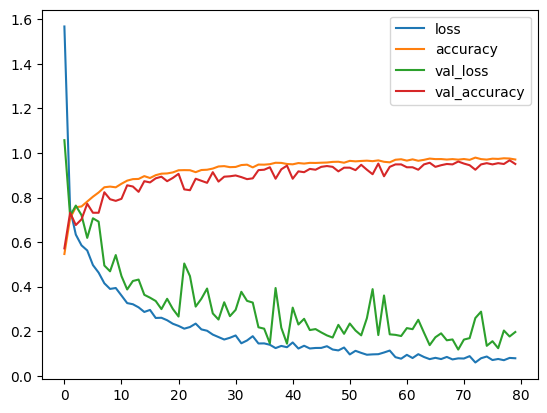

In [14]:
history_df=pd.DataFrame(history.history)
history_df.plot()

In [15]:
scores=model.evaluate(Test_dataset)
scores

19/19 [==============================] - 8s 55ms/step - loss: 0.1611 - accuracy: 0.9493


[0.16106219589710236, 0.9493243098258972]

In [16]:
scores=model.evaluate(Train_dataset)
scores

143/143 [==============================] - 5s 35ms/step - loss: 0.1660 - accuracy: 0.9473


[0.1660219430923462, 0.9473339319229126]

In [17]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidance=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidance

1/1 [==============================] - 0s 19ms/step


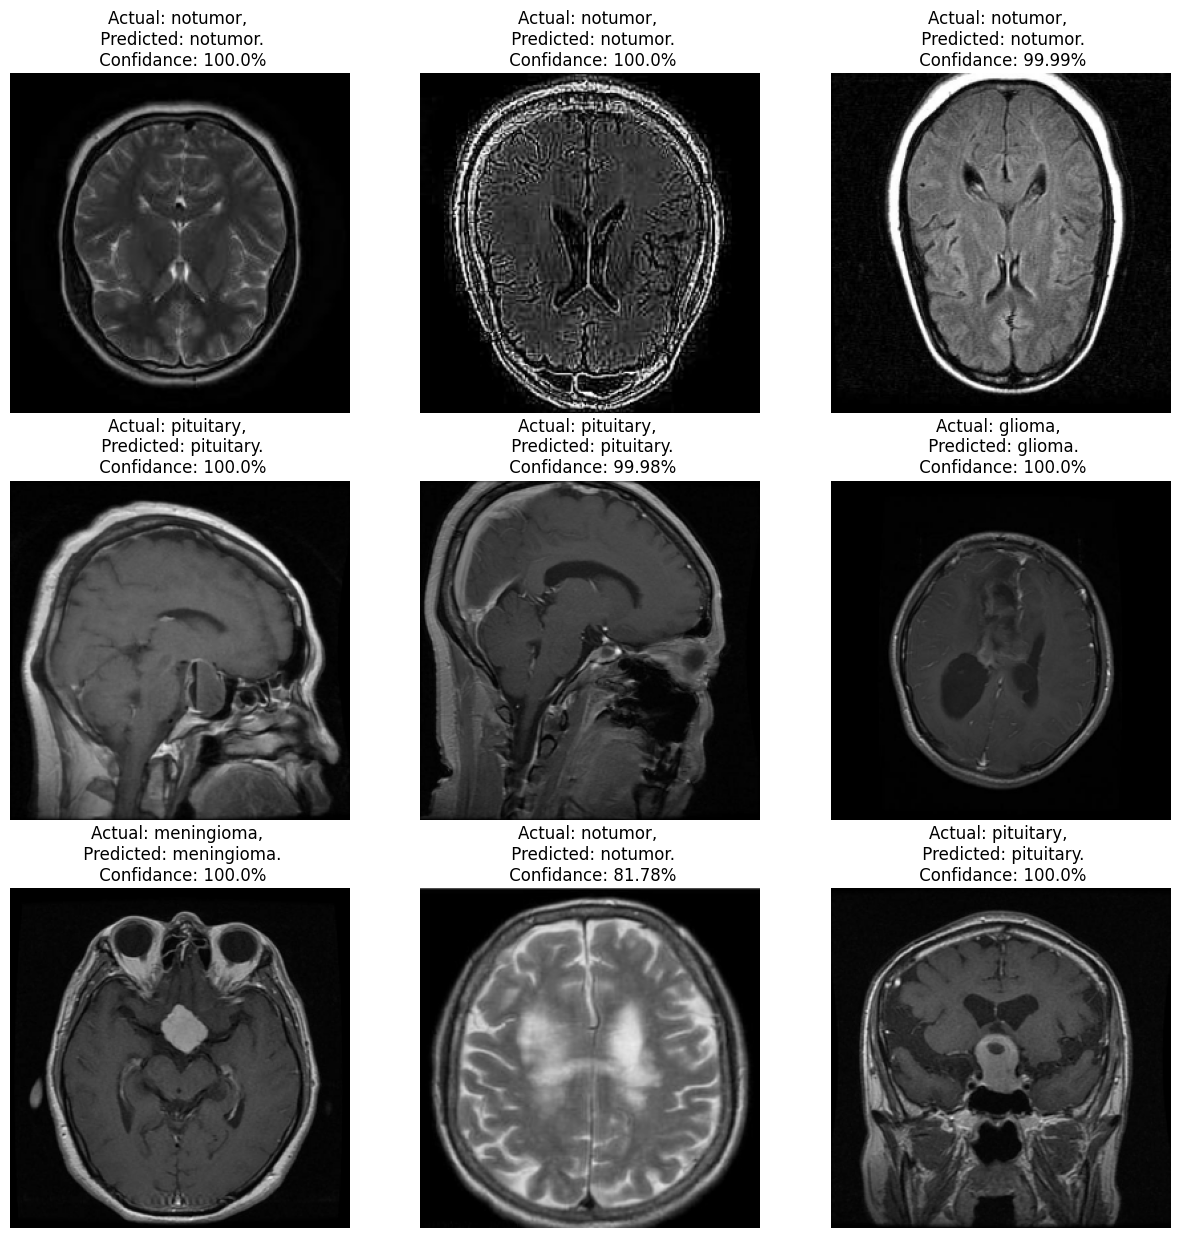

In [18]:
plt.figure(figsize=(15,15))
for images, labels in Test_dataset.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidance=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidance: {confidance}%")
        plt.axis("off")

In [19]:
import os
model_version=max([int(i) for i in os.listdir("./models")+[0]])+1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/6\assets


INFO:tensorflow:Assets written to: ./models/6\assets
